<a href="https://colab.research.google.com/github/aleanaliaaustral-web/labo2025v/blob/main/src/rpart/102_FinalTrain_IntentoDos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbol elemental con libreria  rpart

## Introduccion

Este es el primer notebook/script de la materia Laboratorio de Implementacion I, se expone en la primera clase.
<br>Se utilizan Arboles de Decision, librería **rpart**,  el primer algoritmo, el más simple que utilizaremos en la materia pero que es el fundamento de los Ensembles de Arboles de Decision tales como  Random Forest y  Gradient Boosting of Decision Trees (XGBoost/LightGBM)
<br>La materia posee un dataset con 31 meses, en las primeras clases toda la cohorte, independiente de la modalidad elegida, utilizará **dataset_pequeno** que posee apenas un mes histórico 202107 y obviamente el mes donde se debe realizar la predicción 202109
<br>Este primer notebook/script **no** desarrolla todas las etapas necesarias para la generación de un buen modelo, apenas posee la parte final del pipeline/workflow.

### Limitaciones



Este primer y elemental notebook/script supone estas simplificaciónes:
* Solo se dispone del mes 202107 con el campo clase_ternaria completo, es el unico mes donde entrenar
* Se decidió previamente, de alguna forma, que la etapa de Final Training se hará sobre TODO el dataset de 202107
* Se obtuvieron previamente los hiperparámetros optimos de la libería **rpart** para este problema, mediante algun tipo de busqueda búsqueda.  Esta es la etapa que demandará decenas de horas para quienes opten por la *modalidad Analista Senior*
* No se realiza ningun tipo de feature engineering intra-mes
* Al no disponer de datos históricos no se realiza ningun tipo de feature engineering histórico
* No hay ningun analisis de la calidad de los campos, no se analiza si ocurrió alguna catástrofe ese mes y algun campo no se calculó correctamente
* Noy hay ningun tipo de análisis de Data Drifting entre los meses de 202107 y 202109
* Obedientemente se trabaja utlizando como clase el campo **clase_ternaria** sin ningun tipo de transformacion


<br> Obviamente, a lo largo de la materia se avanzará sobre todas las limitacinoes anteriores.

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/labo1"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/labo1" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/austral2025-af91/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


## Final Train y generacion de la prediccion

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657244,35.2,1454468,77.7,1326121,70.9
Vcells,1220271,9.4,8388608,64.0,1975128,15.1


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table**  **rpart** y  **rpart.plot**

In [2]:
# Cargo las librerías necesarias
require("data.table")
require("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

Loading required package: data.table

Loading required package: rpart

Loading required package: rpart.plot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rpart.plot’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart.plot



In [3]:
# Carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "KA2004_ArbolGridSearch"
dir.create(experimento, showWarnings=FALSE)
setwd(paste0("/content/buckets/b1/exp/", experimento))

In [4]:
# ============================================
# LECTURA DE DATOS
# ============================================

cat("============================================\n")
cat("ÁRBOL DE REGRESIÓN SOBRE GRID SEARCH\n")
cat("============================================\n\n")

# Leo el dataset de grid search
dataset <- fread("/content/buckets/b1/datasets/gridsearch_grupodiez.csv")

cat("Dataset leído correctamente!\n")
cat("Dimensiones:", nrow(dataset), "filas x", ncol(dataset), "columnas\n")
cat("Columnas:", paste(names(dataset), collapse=", "), "\n\n")

# Resumen estadístico
cat("Resumen de ganancia_mean:\n")
cat("  Mínimo:  ", format(min(dataset$ganancia_mean), big.mark=","), "\n")
cat("  Máximo:  ", format(max(dataset$ganancia_mean), big.mark=","), "\n")
cat("  Media:   ", format(mean(dataset$ganancia_mean), big.mark=","), "\n")
cat("  Mediana: ", format(median(dataset$ganancia_mean), big.mark=","), "\n\n")


ÁRBOL DE REGRESIÓN SOBRE GRID SEARCH

Dataset leído correctamente!
Dimensiones: 156 filas x 5 columnas
Columnas: cp, maxdepth, minsplit, minbucket, ganancia_mean 

Resumen de ganancia_mean:
  Mínimo:   31,440,000 
  Máximo:   51,950,000 
  Media:    46,986,346 
  Mediana:  47,520,000 



In [5]:
# ============================================
# PARTICIÓN TRAIN/TEST
# ============================================

# Como el dataset es pequeño, uso 70% train, 30% test
set.seed(123456)
n_total <- nrow(dataset)
n_train <- round(0.7 * n_total)

indices_train <- sample(1:n_total, n_train)

dtrain <- dataset[indices_train]
dtest <- dataset[-indices_train]

cat("Partición de datos:\n")
cat("  Train:", nrow(dtrain), "filas (", round(100*nrow(dtrain)/n_total), "%)\n")
cat("  Test: ", nrow(dtest), "filas (", round(100*nrow(dtest)/n_total), "%)\n\n")

Partición de datos:
  Train: 109 filas ( 70 %)
  Test:  47 filas ( 30 %)



In [6]:
# ============================================
# HIPERPARÁMETROS DEL ÁRBOL
# ============================================

# Para un dataset MUY pequeño uso parámetros muy simples
param_arbol <- list(
  "cp" = 0.001,      # Complejidad muy baja para permitir splits
  "minsplit" = 5,    # Pocos registros para hacer split
  "minbucket" = 2,   # Pocas observaciones por hoja
  "maxdepth" = 5     # Profundidad moderada
)

cat("Hiperparámetros del árbol:\n")
cat("  cp:        ", param_arbol$cp, "\n")
cat("  minsplit:  ", param_arbol$minsplit, "\n")
cat("  minbucket: ", param_arbol$minbucket, "\n")
cat("  maxdepth:  ", param_arbol$maxdepth, "\n\n")

Hiperparámetros del árbol:
  cp:         0.001 
  minsplit:   5 
  minbucket:  2 
  maxdepth:   5 



In [7]:
# ============================================
# ENTRENAMIENTO DEL MODELO
# ============================================

cat("============================================\n")
cat("ENTRENANDO MODELO...\n")
cat("============================================\n\n")

# Modelo de regresión: predigo ganancia_mean a partir de hiperparámetros
modelo <- rpart(
    formula = "ganancia_mean ~ cp + maxdepth + minsplit + minbucket",
    data = dtrain,
    method = "anova",  # Regresión (no clasificación)
    xval = 5,          # Cross-validation con 5 folds
    control = param_arbol
)

cat("Modelo entrenado!\n\n")

# Información del modelo
print(modelo)

# Importancia de variables
if (!is.null(modelo$variable.importance)) {
  cat("\n\nImportancia de variables:\n")
  print(modelo$variable.importance)
}


ENTRENANDO MODELO...

Modelo entrenado!

n= 109 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 109 1.345301e+15 46819360  
   2) minsplit< 60 9 2.895174e+14 41983330  
     4) maxdepth>=12 4 3.109988e+13 36167500 *
     5) maxdepth< 12 5 1.488532e+13 46636000  
      10) minbucket< 10 2 3.125000e+10 45005000 *
      11) minbucket>=10 3 5.986867e+12 47723330 *
   3) minsplit>=60 100 8.263559e+14 47254600  
     6) minsplit< 250 32 4.330702e+14 45876250  
      12) minbucket>=32.5 8 9.162515e+13 41402500  
        24) maxdepth>=12 4 0.000000e+00 38460000 *
        25) maxdepth< 12 4 2.235870e+13 44345000 *
      13) minbucket< 32.5 24 1.279576e+14 47367500  
        26) maxdepth>=12 9 5.952600e+12 45300000  
          52) cp< -0.45 3 3.081867e+12 44506670 *
          53) cp>=-0.45 6 3.853333e+10 45696670 *
        27) maxdepth< 12 15 6.045144e+13 48608000  
          54) maxdepth< 8 5 5.241720e+12 46524000 *
          55) maxdepth>=8 10 2.263680e+13 49650000 *




Generando visualización del árbol...


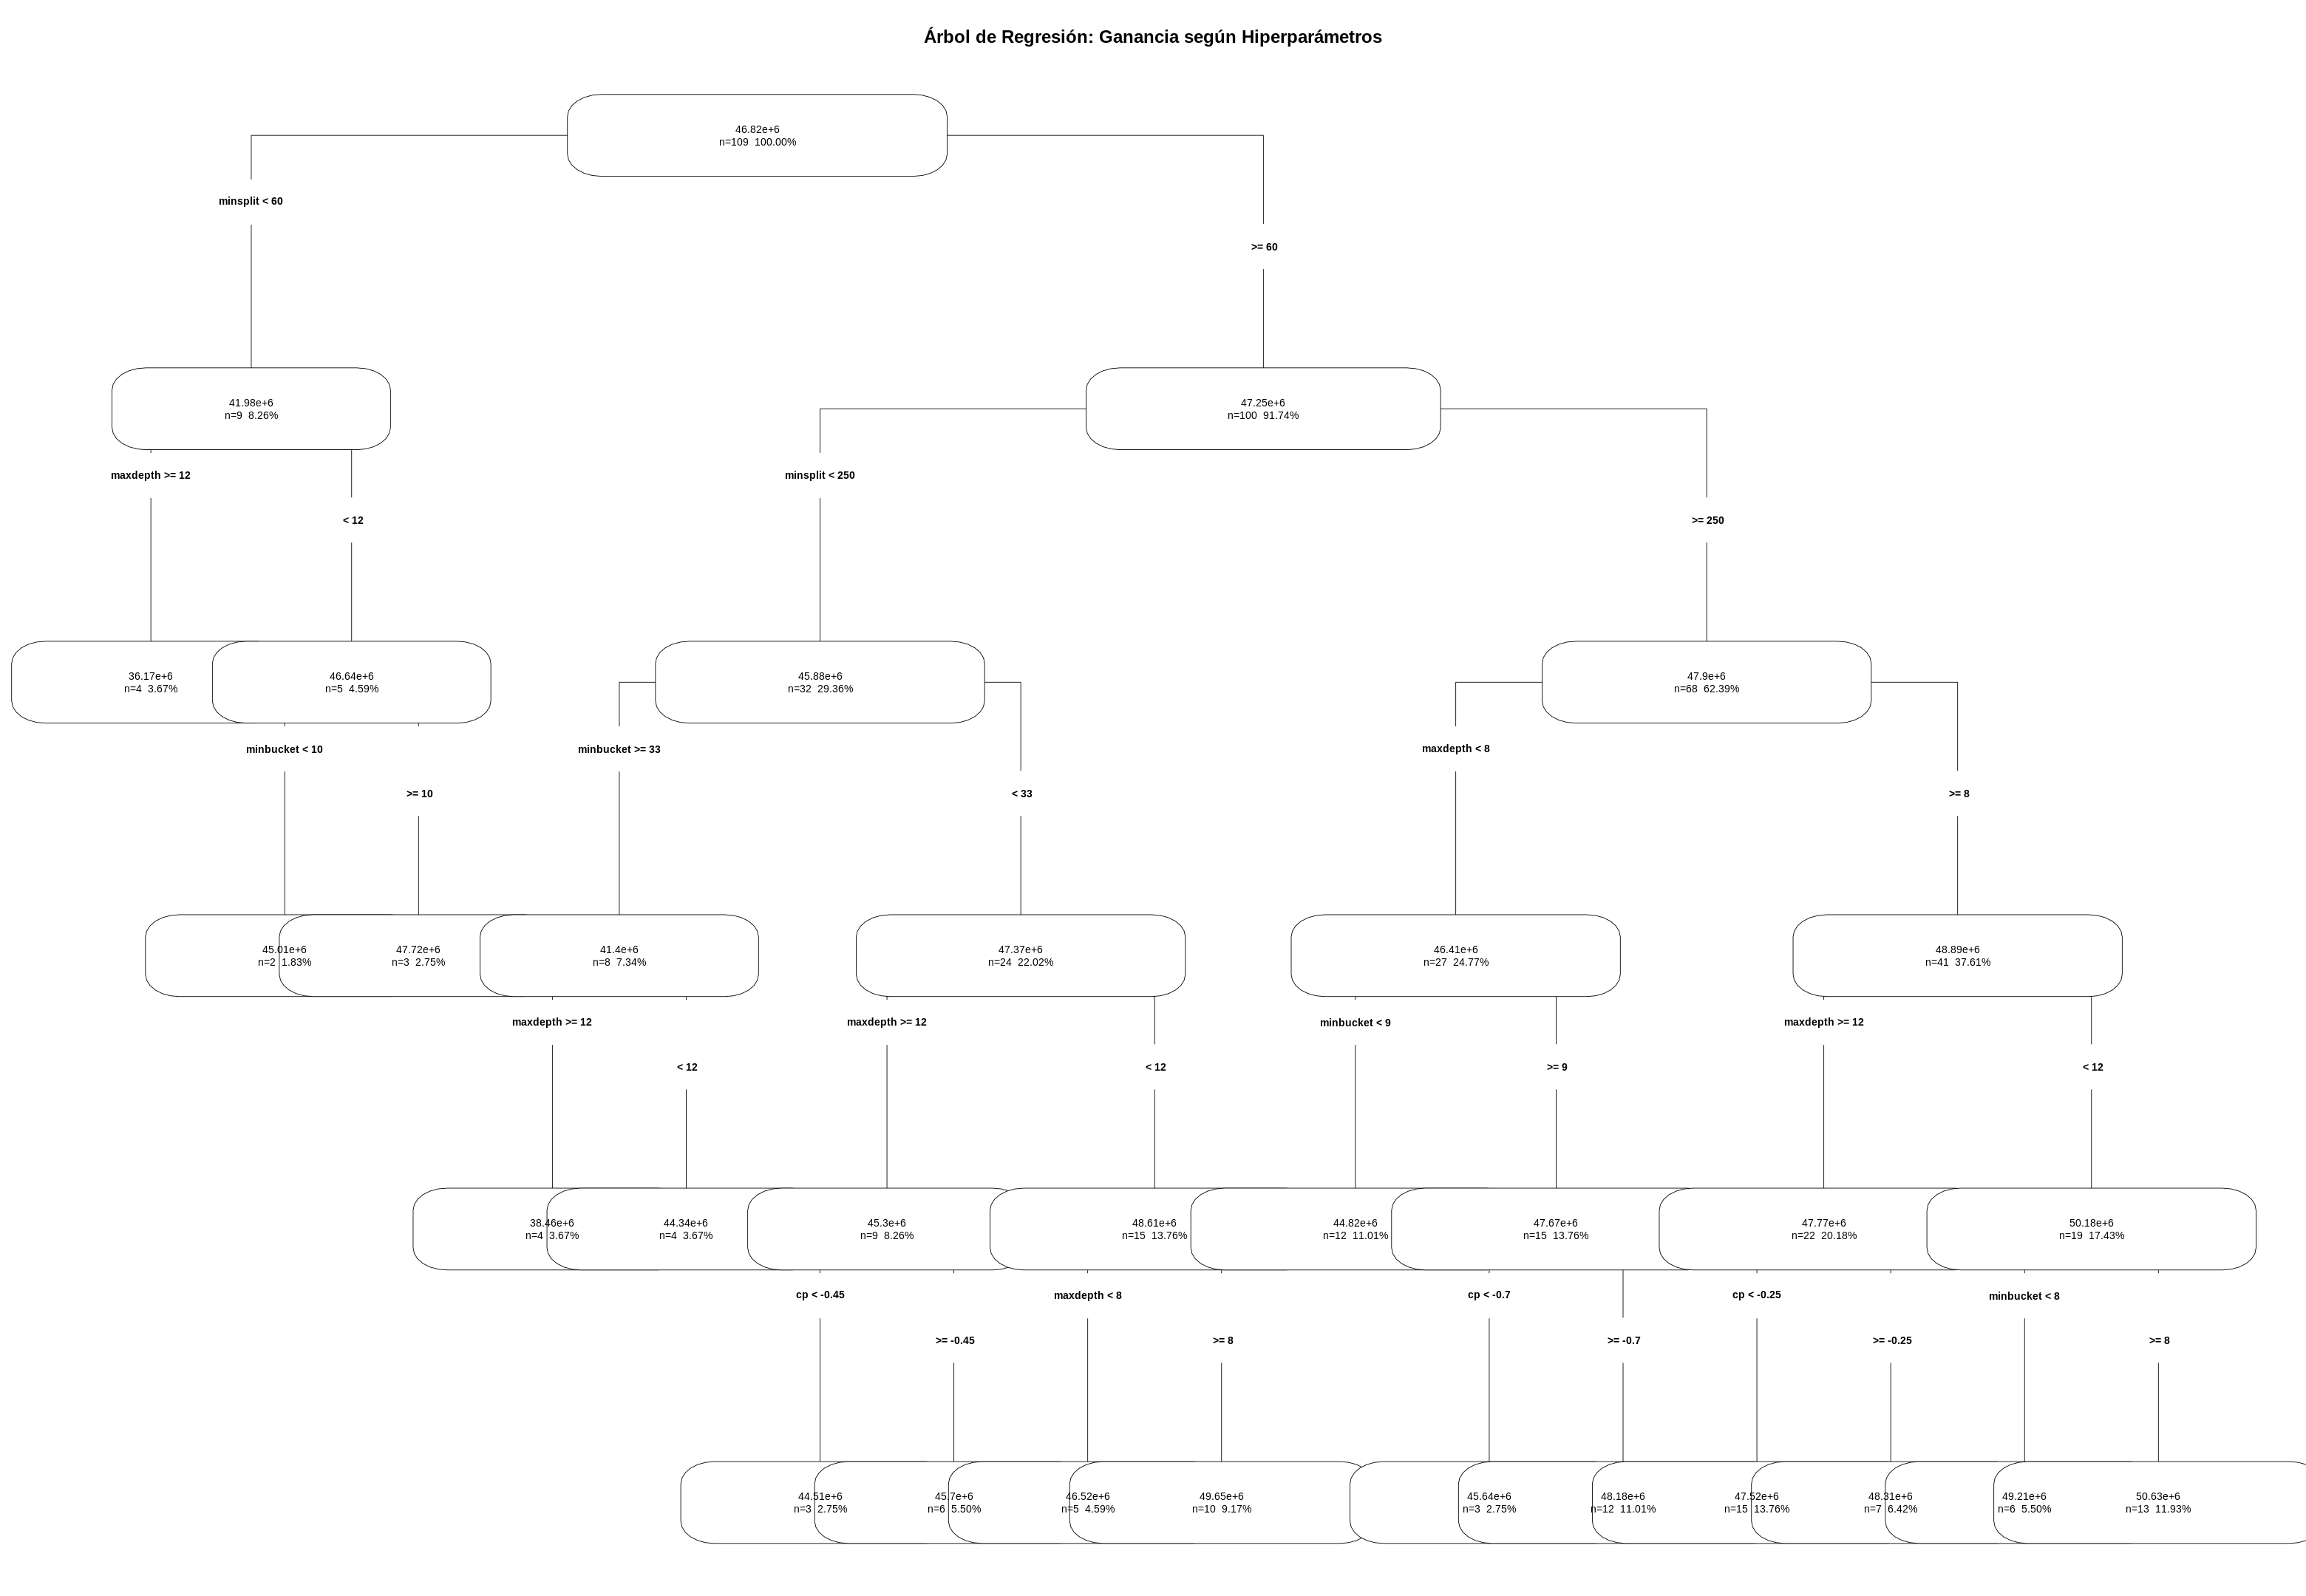

In [8]:
# ============================================
# VISUALIZACIÓN DEL ÁRBOL
# ============================================

cat("\n\nGenerando visualización del árbol...\n")

# Configurar tamaño del gráfico
options(repr.plot.width=26, repr.plot.height=18)

# Grafico el árbol con letra más grande y sin colores
prp(modelo,
    extra = 101,        # Muestra n y media
    digits = 4,         # 4 decimales
    branch = 1,
    type = 4,
    varlen = 0,
    faclen = 0,
    cex = 0.7,          # Tamaño de letra reducido
    cex.main = 1.2,     # Tamaño del título
    box.col = "white",  # Sin colores en las cajas
    border.col = "black",  # Bordes negros
    main = "Árbol de Regresión: Ganancia según Hiperparámetros"
)


In [9]:
# ============================================
# PREDICCIÓN Y EVALUACIÓN
# ============================================

cat("\n\n============================================\n")
cat("EVALUACIÓN DEL MODELO\n")
cat("============================================\n\n")

# Predicciones en TRAIN
pred_train <- predict(modelo, newdata = dtrain)
dtrain[, pred_ganancia := pred_train]

# Predicciones en TEST
pred_test <- predict(modelo, newdata = dtest)
dtest[, pred_ganancia := pred_test]

# Función para calcular métricas
calcular_metricas <- function(real, pred) {
  mae <- mean(abs(real - pred))
  rmse <- sqrt(mean((real - pred)^2))
  r2 <- cor(real, pred)^2

  list(mae = mae, rmse = rmse, r2 = r2)
}

# Métricas en TRAIN
metricas_train <- calcular_metricas(dtrain$ganancia_mean, dtrain$pred_ganancia)

cat("TRAIN:\n")
cat("  MAE:  ", format(metricas_train$mae, big.mark=",", digits=2), "\n")
cat("  RMSE: ", format(metricas_train$rmse, big.mark=",", digits=2), "\n")
cat("  R²:   ", round(metricas_train$r2, 4), "\n\n")

# Métricas en TEST
metricas_test <- calcular_metricas(dtest$ganancia_mean, dtest$pred_ganancia)

cat("TEST:\n")
cat("  MAE:  ", format(metricas_test$mae, big.mark=",", digits=2), "\n")
cat("  RMSE: ", format(metricas_test$rmse, big.mark=",", digits=2), "\n")
cat("  R²:   ", round(metricas_test$r2, 4), "\n\n")



EVALUACIÓN DEL MODELO

TRAIN:
  MAE:   868,215 
  RMSE:  1,188,549 
  R²:    0.8855 

TEST:
  MAE:   1e+06 
  RMSE:  1,593,875 
  R²:    0.6552 



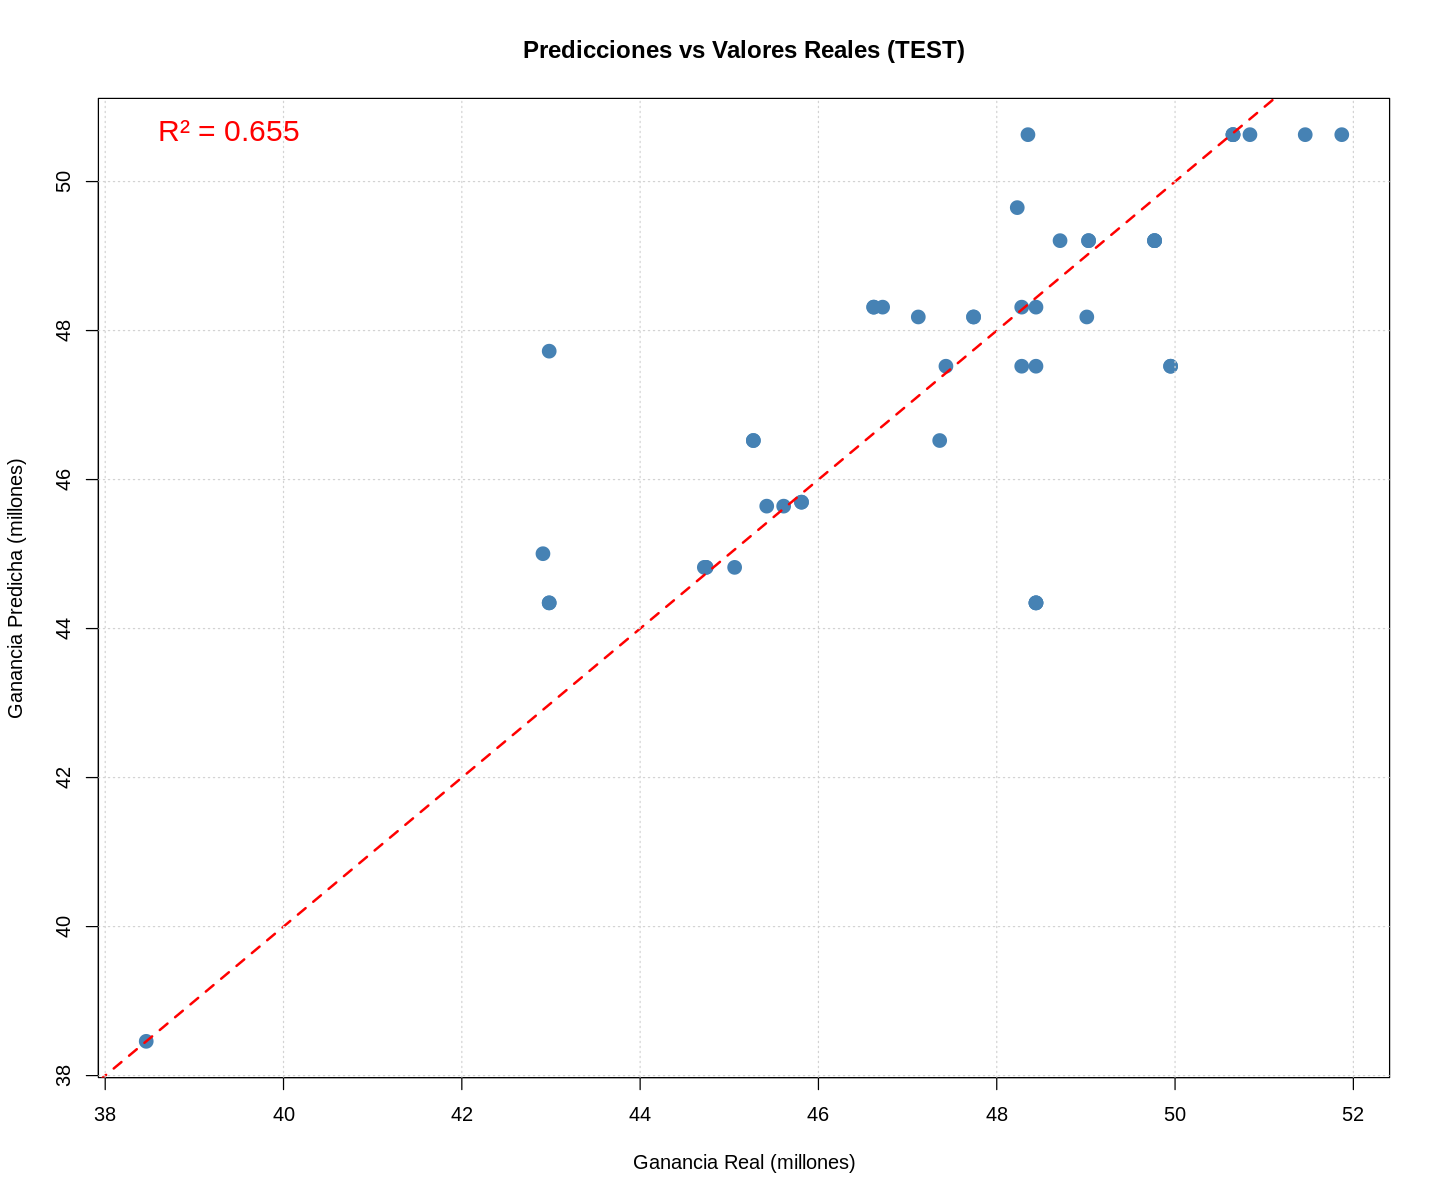

In [10]:
# ============================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================

# Gráfico 1: Predicciones vs Reales en TEST
options(repr.plot.width=12, repr.plot.height=10)

plot(dtest$ganancia_mean / 1e6, dtest$pred_ganancia / 1e6,
     xlab = "Ganancia Real (millones)",
     ylab = "Ganancia Predicha (millones)",
     main = "Predicciones vs Valores Reales (TEST)",
     pch = 19,
     col = "steelblue",
     cex = 1.5)
abline(0, 1, col = "red", lwd = 2, lty = 2)  # Línea y=x
grid()

# Agregar texto con R²
text(x = min(dtest$ganancia_mean)/1e6,
     y = max(dtest$pred_ganancia)/1e6,
     labels = paste0("R² = ", round(metricas_test$r2, 3)),
     pos = 4, cex = 1.5, col = "red")

In [11]:
# ============================================
# ANÁLISIS DE MEJORES CONFIGURACIONES
# ============================================

cat("\n============================================\n")
cat("ANÁLISIS DE CONFIGURACIONES\n")
cat("============================================\n\n")

# TOP 10 configuraciones reales
cat("TOP 10 MEJORES (datos reales):\n")
top10_real <- dataset[order(-ganancia_mean)][1:10]
print(top10_real)

cat("\n\nTOP 10 PEORES (datos reales):\n")
top10_peor <- dataset[order(ganancia_mean)][1:10]
print(top10_peor)



ANÁLISIS DE CONFIGURACIONES

TOP 10 MEJORES (datos reales):
       cp maxdepth minsplit minbucket ganancia_mean
    <num>    <int>    <int>     <int>         <num>
 1: -0.50       10      400        50      51950000
 2: -0.40       10      400        50      51950000
 3: -0.30       10      400        50      51950000
 4: -0.20       10      400        50      51950000
 5: -0.01       10      400        50      51950000
 6: -0.50       10     1000        15      51870000
 7: -0.40       10     1000        10      51460000
 8: -0.30       10     1000        10      51460000
 9: -0.20       10     1000        10      51460000
10: -0.01       10     1000        10      51460000


TOP 10 PEORES (datos reales):
       cp maxdepth minsplit minbucket ganancia_mean
    <num>    <int>    <int>     <int>         <num>
 1: -0.50       14       20         5      31440000
 2: -0.50       14       20        15      36870000
 3: -0.50       14       20         1      37900000
 4: -0.50       14     

In [12]:
# ============================================
# GUARDAR RESULTADOS
# ============================================

# Guardo predicciones en test
fwrite(dtest[, .(cp, maxdepth, minsplit, minbucket, ganancia_mean, pred_ganancia)],
       file = "predicciones_test.csv")

# Guardo métricas
metricas_resumen <- data.table(
  Conjunto = c("TRAIN", "TEST"),
  MAE = c(metricas_train$mae, metricas_test$mae),
  RMSE = c(metricas_train$rmse, metricas_test$rmse),
  R2 = c(metricas_train$r2, metricas_test$r2)
)

fwrite(metricas_resumen, file = "metricas.csv")

cat("\n\nArchivos guardados:\n")
cat("  - predicciones_test.csv\n")
cat("  - metricas.csv\n")

cat("\n============================================\n")
cat("¡ANÁLISIS COMPLETADO!\n")
cat("============================================\n")



Archivos guardados:
  - predicciones_test.csv
  - metricas.csv

¡ANÁLISIS COMPLETADO!
